A while ago (in december) I had a meeting with stephen, these were some points raised
1. (done) Better reject high spurious center of mass values. The discrimination criterion should be based on a minimum number
of significant bins for the dprime based on a chance cutout
2. Do most of the analysis should on cell-probe pairs (use id_probe in DF)
3. are contextual effects independent of  probe?? if for one probe there are contextual effects, is there expected that
they also exist for other probes?
4 for the region comparisons, do them independently for each transition pair, as pooling across all of them might be
averaging out the effects, when there is no significant contextual effects.
5. conversely, for comparison of the effects of context transitions, further discriminate based on region
6. For a probe, display differences between context with a node-edge graph.


In [91]:
import itertools as itt
from pathlib import Path
from configparser import ConfigParser
from textwrap import fill

import joblib as jl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sst
import seaborn as sns
from cycler import cycler
from ipywidgets import interact, interact_manual, fixed

from src.data.region_map import region_map
from src.metrics.dprime import flip_dprimes
from src.metrics.consolidated_dprimes_v2 import single_cell_dprimes, probewise_LDA_dprimes, probewise_dPCA_dprimes, full_dPCA_dprimes
from src.metrics.consolidated_metrics import _append_means_to_array, metrics_to_DF, _append_means_to_shuff_array
from src.metrics.significance import _significance, _mask_with_significance

In [2]:


plt.style.use('dark_background')
# modify figure color cycler back to the default one
color_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

params = {'legend.fontsize': 'medium',
          'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': color_cycler,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [6,6],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial'
          }

plt.rcParams.update(params)

In [3]:
config = ConfigParser()
config.read_file(open(Path('../config/settings.ini')))

In [4]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path('../data/210302_consolidated_summary_DF_alpha_0.01/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))
DF['id'] = DF['cellid'].fillna(value=DF['siteid'])
DF['id_probe'] = DF[['id', 'probe']].agg('_'.join, axis=1)

DF = DF.drop(columns=['cellid', 'siteid'])

print('duplicated columns?: ', any(DF.loc[:,[col for col in DF.columns if col !='value']].duplicated()))

duplicated columns?:  False


## parameter space scaterplots
### for context and probe means

In [10]:
print(DF.columns)
print(DF.mult_comp_corr.unique())
print(DF.mean_signif_type.unique())

Index(['context_pair', 'probe', 'value', 'metric', 'mult_comp_corr',
       'mean_signif_type', 'stim_type', 'analysis', 'region', 'id',
       'id_probe'],
      dtype='object')
['none' 'full' 'consecutive_2' 'consecutive_3' 'consecutive_4']
['zeros' 'mean' 'shuffles']


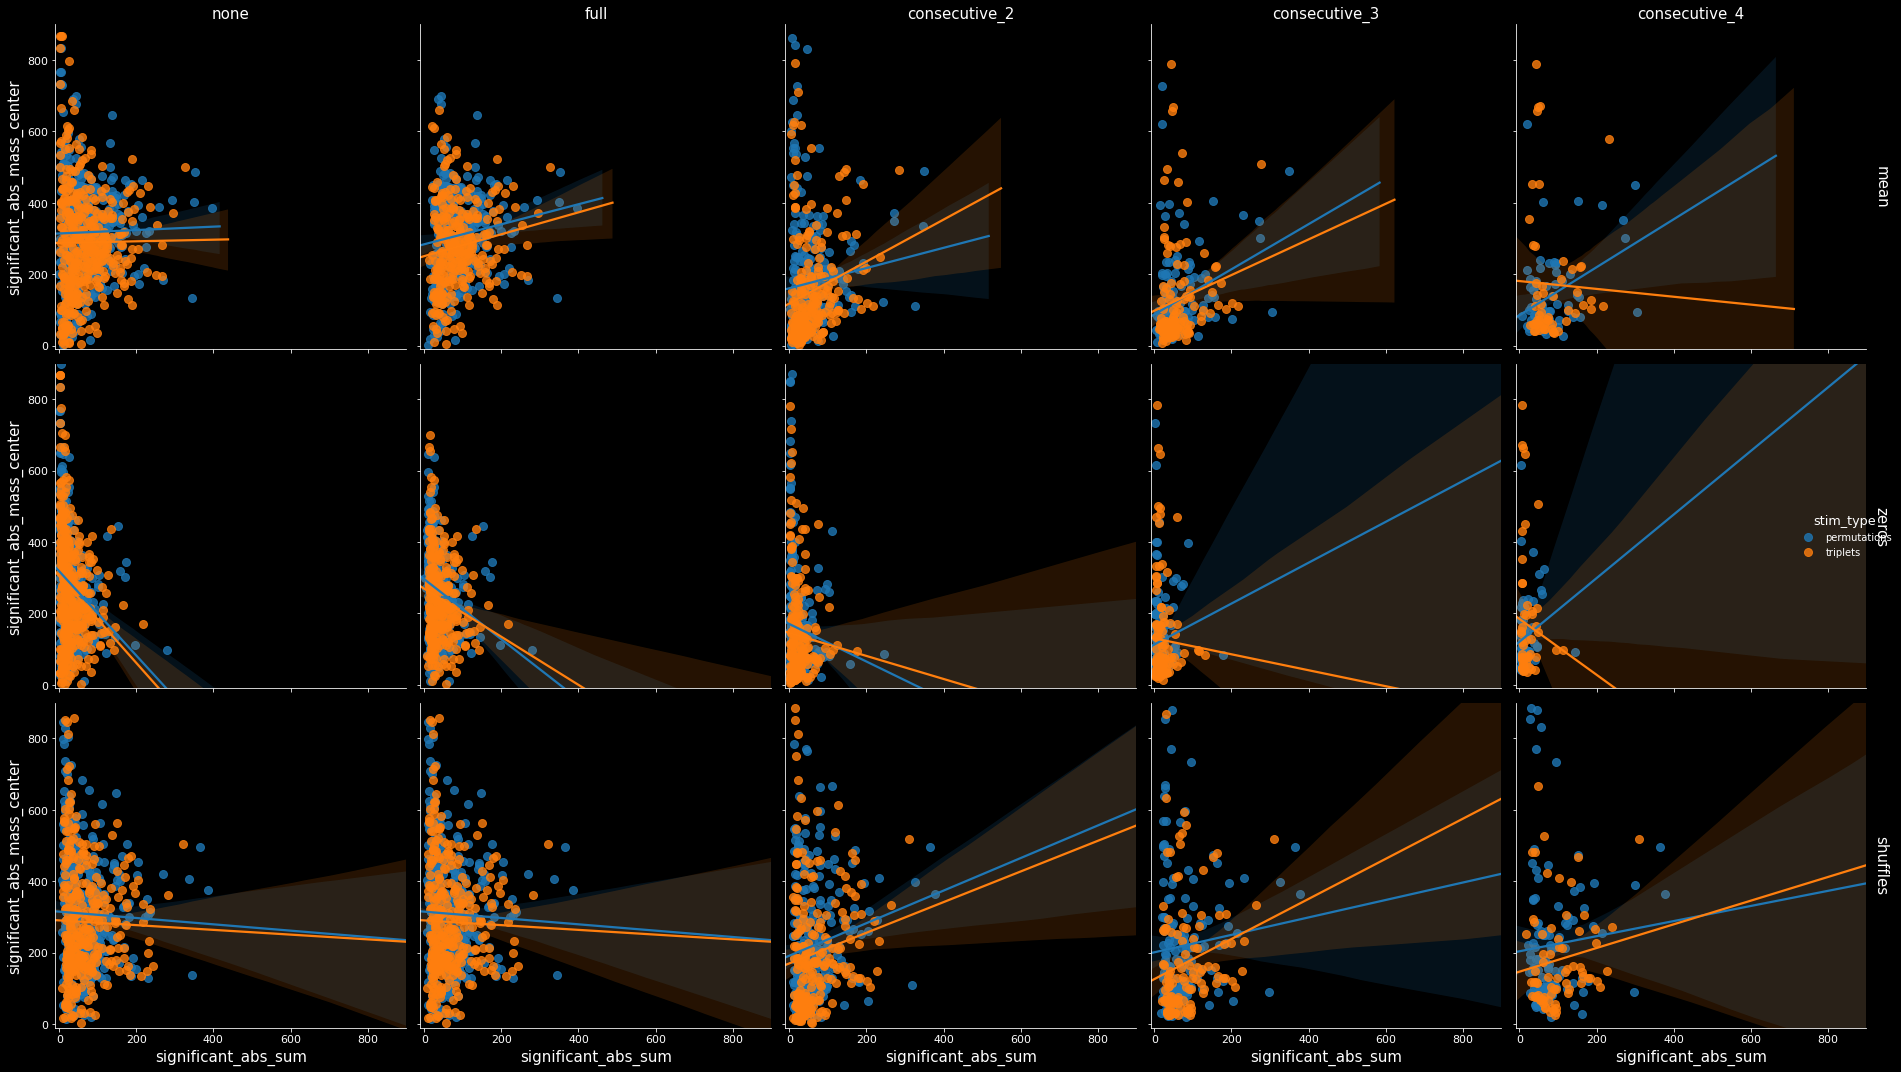

In [20]:
ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe == 'mean'
ff_analysis = DF.analysis == 'SC'
good_cols = [col for col in DF.columns if col not in ['value', 'id_probe', 'probe', 'context_pair', 'analysis', 'region`']]
pivot_cols = [col for col in good_cols if col not in ['value', 'metric']]

filtered = DF.loc[ff_ctx & ff_prb & ff_analysis,:]
# print(any(filtered.loc[:,good_cols].duplicated()))
toplot = filtered.pivot_table(index=pivot_cols, columns='metric', values='value', aggfunc='first').reset_index()
toplot = toplot.loc[(toplot.significant_abs_sum!=0) & (toplot.significant_abs_mass_center!=0),:]
# note that 'LDA' can be added the the col_order
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mass_center',data=toplot,
               row='mean_signif_type', col='mult_comp_corr', hue='stim_type',
               row_order=['mean', 'zeros', 'shuffles'], col_order=['none', 'full', 'consecutive_2', 'consecutive_3', 'consecutive_4'],
               sharex=True, sharey=True)
ax = g.axes[0,0]
ax.set_xlim(-10,900)
ax.set_ylim(-10,900)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")



### same as before but for id_probes

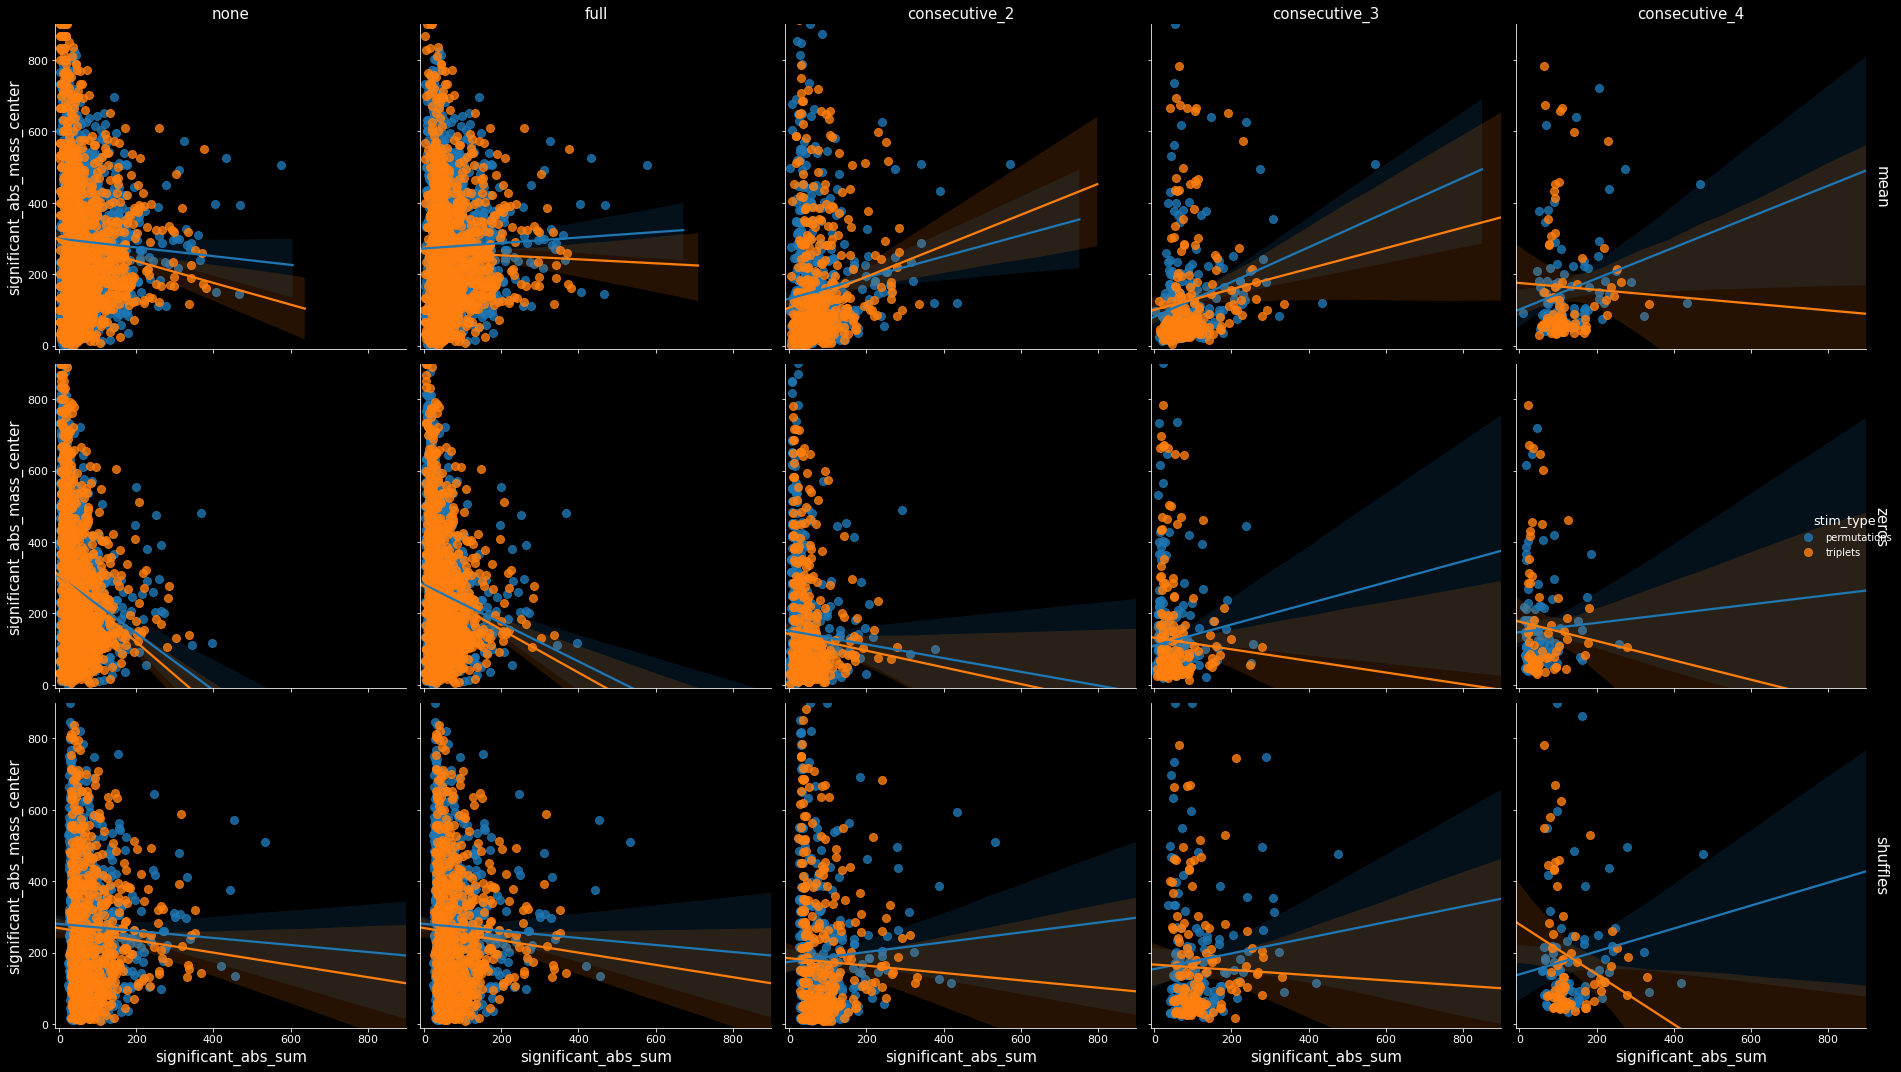

In [21]:
ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe != 'mean'
ff_analysis = DF.analysis == 'SC'
good_cols = [col for col in DF.columns if col not in ['value', 'probe', 'context_pair', 'id', 'region', 'analysis']]
pivot_cols = [col for col in good_cols if col not in ['value', 'metric']]

filtered = DF.loc[ff_ctx & ff_prb & ff_analysis,:]
# print(any(filtered.loc[:,good_cols].duplicated()))
toplot = filtered.pivot_table(index=pivot_cols, columns='metric', values='value', aggfunc='first').reset_index()
toplot = toplot.loc[(toplot.significant_abs_sum!=0) & (toplot.significant_abs_mass_center!=0),:]
# note that 'LDA' can be added the the col_order
g = sns.lmplot(x='significant_abs_sum', y='significant_abs_mass_center',data=toplot,
               row='mean_signif_type', col='mult_comp_corr', hue='stim_type',
               row_order=['mean', 'zeros', 'shuffles'], col_order=['none', 'full', 'consecutive_2', 'consecutive_3', 'consecutive_4'],
               sharex=True, sharey=True)
ax = g.axes[0,0]
ax.set_xlim(-10,900)
ax.set_ylim(-10,900)

g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")


Its unexpected to see such a late single cell significances with consecutive_4 correction.

what are those outliers?:

In [102]:
# get some outlierse for SC and dPCA with low integral and high center of mass

ff_ctx = DF.context_pair == 'mean'
ff_prb = DF.probe == 'mean'
ff_analysis = DF.analysis == 'SC'
ff_corr = DF.mult_comp_corr != 'none'

good_cols = [col for col in DF.columns if col not in ['id_probe', 'context_pair', 'probe', 'analysis', 'region']]
pivot_cols = [col for col in good_cols if col not in ['value', 'metric']]
filtered = DF.loc[ff_ctx & ff_prb & ff_analysis & ff_corr, good_cols]
# print(any(filtered.loc[:, good_cols].duplicated()))
pivoted = filtered.pivot_table(index=pivot_cols, columns='metric', values='value', aggfunc='first')
pivoted = pivoted.loc[(pivoted.significant_abs_mass_center!=0)&(pivoted.significant_abs_sum!=0),:]
sorted = pivoted.sort_values(['significant_abs_mass_center', 'significant_abs_sum'], axis=0, ascending=[0,1])
sorted
# print(sorted.head(10))

metric                                                     significant_abs_mass_center  \
mult_comp_corr mean_signif_type stim_type    id                                          
consecutive_2  mean             permutations AMT028b-04-1                   966.040013   
               zeros            permutations AMT028b-04-1                   950.572803   
               shuffles         triplets     AMT026a-04-3                   949.933905   
                                permutations CRD012b-27-3                   948.940829   
               mean             permutations ley075b-12-1                   921.294807   
               zeros            permutations ley075b-12-1                   918.541963   
                                             AMT030a-17-1                   916.900357   
               mean             permutations AMT030a-17-1                   915.431557   
consecutive_4  shuffles         permutations CRD018d-39-3                   886.101367   
consecutive_2  shuffles         triplets     ley072b-18-1                   885.096899   
consecutive_3  shuffles         permutations CRD011c-30-3                   878.324643   
consecutive_4  shuffles         permutations CRD011c-30-3                   878.324643   
consecutive_2  zeros            permutations AMT030a-03-2                   871.242887   
consecutive_3  shuffles         triplets     AMT029a-06-1                   868.688001   
consecutive_2  mean             permutations CRD004a-46-4                   861.127704   
full           shuffles         triplets     AMT026a-04-3                   856.289872   
consecutive_3  shuffles         permutations ley072b-11-1                   853.634316   
consecutive_4  shuffles         permutations ley072b-11-1                   853.634316   
consecutive_2  shuffles         triplets     ley070a-18-2                   850.641206   
full           shuffles         triplets     ley070a-18-2                   850.641206   
consecutive_2  zeros            permutations CRD004a-46-4                   849.882623   
                                             AMT030a-09-4                   849.358023   
full           shuffles         permutations AMT032a-24-1                   847.396815   
                                triplets     ley070a-20-1                   845.459191   
consecutive_2  mean             permutations AMT030a-09-4                   842.617213   
consecutive_4  shuffles         permutations CRD003b-03-1                   830.819017   
consecutive_2  mean             permutations AMT030a-03-2                   830.772980   
full           shuffles         permutations AMT030a-28-2                   829.309971   
consecutive_2  shuffles         triplets     CRD003b-37-1                   812.540025   
full           shuffles         triplets     CRD003b-37-1                   812.540025   
...                                                                                ...   
consecutive_2  zeros            triplets     AMT028b-15-2                    11.355499   
               mean             permutations ley070a-18-2                    11.350420   
               shuffles         permutations ley070a-18-2                    11.350420   
                                triplets     CRD011c-20-1                    11.342816   
                                             CRD018d-45-2                    10.879798   
               mean             triplets     CRD018d-33-3                    10.734419   
               shuffles         triplets     CRD018d-33-3                    10.734419   
               zeros            triplets     CRD003b-41-1                    10.627089   
               mean             permutations CRD011c-40-4                    10.607900   
full           zeros            triplets     CRD019b-46-4                    10.481586   
                                permutations AMT028b-55-1                    10.373316   
consecutive_2  shuffles         triplets

there are plenty of culprits for single cell, and a couple for dPCA:
* fdPCA, ley075b
* pdPCA, ley075b
* SC, CRD018d-39-3
* SC, CRD011c-30-3

It is worth plotting the raw dprime traces and perhaps thinking a new significance correction... at least the function
already exists and should be easy to exted.

In [99]:

def plot_signif_summary(site, cellid, expt_name, fname, corr_name, mean_type, context_pair=-1, probe=-1, grid=False):
    alpha=0.01
    meta = {'reliability': 0.1,  # r value
            'smoothing_window': 0,  # ms
            'raster_fs': 30,
            'montecarlo': 1000,
            'zscore': True,
            'dprime_absolute': None}

    analysis_functions = {'SC': single_cell_dprimes,'LDA':probewise_LDA_dprimes,
                          'pdPCA': probewise_dPCA_dprimes, 'fdPCA': full_dPCA_dprimes}


    permutations = {'contexts': [0, 1, 2, 3, 4],
                    'probes': [1, 2, 3, 4],
                    'stim_type': 'permutations'}

    triplets = {'contexts': ['silence', 'continuous', 'similar', 'sharp'],
                'probes':[2, 3, 5, 6],
                'stim_type': 'triplets'}

    experiments = {'permutations':permutations, 'triplets':triplets}

    multiple_corrections = {'none': (None, None),
                            'full': ([1,2,3], None),
                            'time': ([3], None),
                            'probe': ([2,3], None),
                            'context_pair': ([1,3], None),
                            'consecutive_2': ([3], 2),
                            'consecutive_3': ([3], 3),
                            'consecutive_4': ([3], 4)}



    expt = experiments[expt_name]
    func = analysis_functions[fname]
    corr, cons = multiple_corrections[corr_name]


    # skips full_dPCA for the triplets experiment
    if expt['stim_type'] == 'triplets' and fname == 'fdPCA':
        print('invalid combination.  Triplets cant use fdPCA')

    print(site, expt['stim_type'], fname, corr_name, mean_type)

    # parses the stim_type from the experiment into the meta parameters
    expt = expt.copy()
    meta['stim_type'] = expt.pop('stim_type')

    # runs the dprime function
    dprime, shuffled_dprime, goodcells, var_capt = func(site, **expt, meta=meta)

    # for analysis with dimensionality reduction, changes the cellname to nan for proper dimension labeling.
    if fname != 'SC':
        chan_name = [np.nan]
        cell = 0
    else:
        chan_name = goodcells
        cell = goodcells.index(cellid)

    # creates label dictionalry
    dim_lab_dict = {'cellid': chan_name,
                    'context_pair': [f'{c1}_{c2}' for c1, c2 in itt.combinations(expt['contexts'], 2)],
                    'probe': expt['probes'],
                    'time': np.linspace(0, dprime.shape[-1] / meta['raster_fs'], dprime.shape[-1],
                                        endpoint=False) * 1000}

    # calculates different significaces/corrections
    # calculate significant time bins, both raw and corrected for multiple comparisons

    significance, confidence_interval = _significance(dprime, shuffled_dprime, corr, cons, alpha=alpha)
    fliped, fliped_shuffled = flip_dprimes(dprime, shuffled_dprime, flip='sum')

    # only time correction for the means

    dprime_means, _  = _append_means_to_array(fliped, dim_lab_dict)
    shuff_means, _  = _append_means_to_shuff_array(fliped_shuffled, dim_lab_dict)

    raw_signif, _ = _significance(dprime_means, shuff_means, None, None, alpha)
    shuf_signif, shuf_CI = _significance(dprime_means, shuff_means, [3], cons, alpha=alpha)

    # masks dprime with different significances, uses different approaches to define significance of the mean.
    masked, masked_lab_dict = _mask_with_significance(fliped, significance, dim_lab_dict, mean_type=mean_type,
                                                  mean_signif_arr=shuf_signif)


    if isinstance(masked.mask, np.ndarray):
        corr_signif = ~masked.mask
    elif masked.mask == False:
        corr_signif, _ = _append_means_to_array(significance, dim_lab_dict)


    CI = shuf_CI.copy()
    CI[:,:,:-1,:-1,:] = confidence_interval

    # calculate different metrics and organize into a dataframe
    df = metrics_to_DF(masked, masked_lab_dict, metrics=['significant_abs_mass_center', 'significant_abs_sum'])

    t = dim_lab_dict['time']

    bar_bottom = -0.5
    bar_width = 1000/30

    # plots all context probes and means
    if grid:
        fig, axes = plt.subplots(len(masked_lab_dict['probe']), len(masked_lab_dict['context_pair']),
                                 sharex='all', sharey='all', figsize=(20,10))
        for (tt, trans_pair),(pp, probe) in itt.product(enumerate(masked_lab_dict['context_pair']),
                                                        enumerate(masked_lab_dict['probe'])):

            ax = axes[pp,tt]
            _ = ax.plot(t, dprime_means[cell, tt, pp, :], color='white', label='dprime')

            _ = ax.fill_between(t, CI[0, cell, tt, pp, :], CI[1,cell, tt, pp, :],
                            color='gray', alpha=0.5, label=f'{(1-alpha)*100}% confidence interval')

            _ = ax.bar(t, raw_signif[cell, tt, pp, :], width=bar_width, align='center', color='purple',
                   edgecolor='white', bottom=bar_bottom, alpha=0.5, label='raw_signif')

            _ = ax.bar(t, corr_signif[cell, tt, pp, :], width=bar_width, align='center', color='green',
                   edgecolor='white', bottom=bar_bottom+bar_bottom, alpha=0.5, label='corr_signif')

        # _ = ax.legend()

    # plots specific context and probe
    elif grid == False:
        fig, ax = plt.subplots()
        _ = ax.plot(t, dprime_means[cell, context_pair, probe, :], color='white', label='dprime')


        _ = ax.fill_between(t, CI[0, cell, context_pair, probe, :], CI[1,cell, context_pair, probe, :],
                        color='gray', alpha=0.5, label=f'{(1-alpha)*100}% confidence interval')

        ax_bott = -0.5
        _ = ax.bar(t, raw_signif[cell, context_pair, probe, :], width=bar_width, align='center', color='purple',
               edgecolor='white', bottom=ax_bott, alpha=0.5, label='raw_signif')

        _ = ax.bar(t, corr_signif[cell, context_pair, probe, :], width=bar_width, align='center', color='green',
               edgecolor='white', bottom=ax_bott+ax_bott, alpha=0.5, label='corr_signif')

        _ = ax.legend()

    return None

AMT028b permutations SC consecutive_2 mean


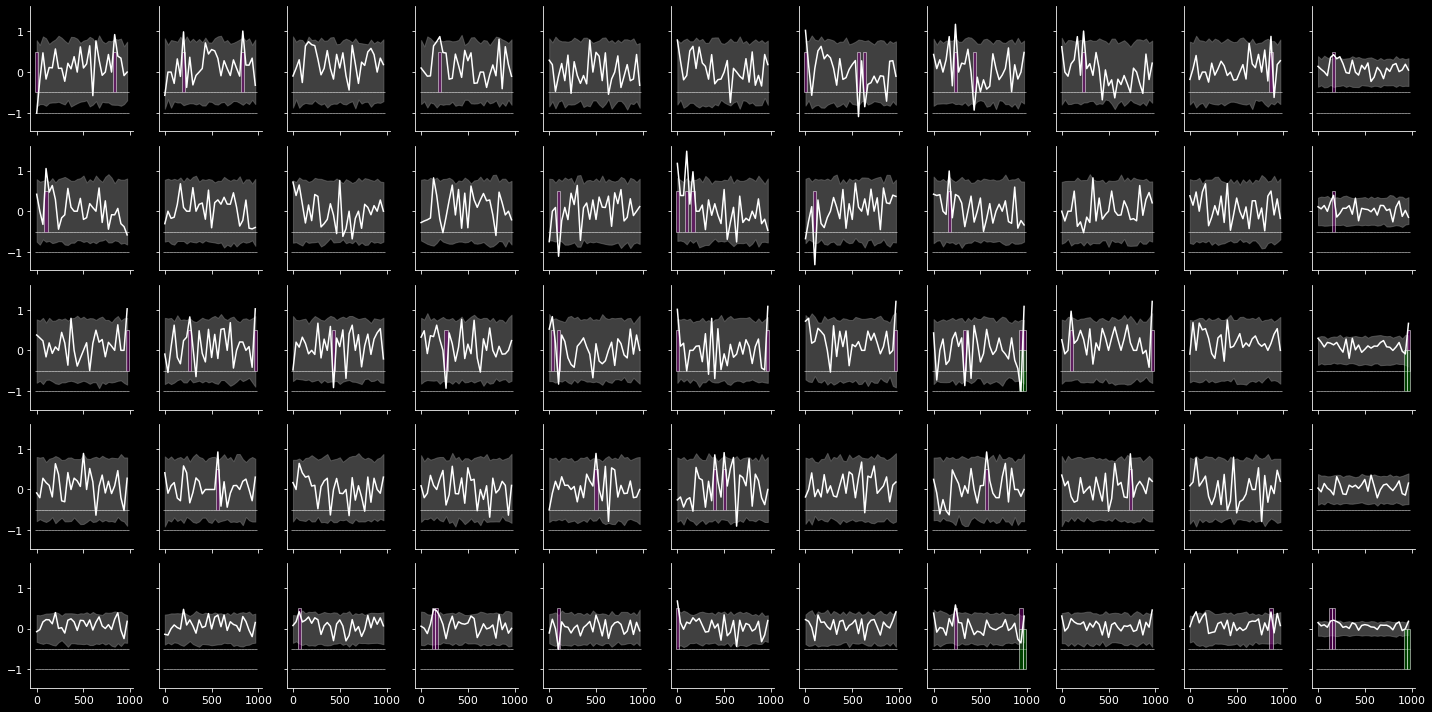

In [77]:
cellid = 'AMT028b-04-1'
site = 'AMT028b'
expt_name = 'permutations'
fname = 'SC'
mult_corr = 'consecutive_2'
mean_type = 'mean'
_  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, mean_type, context_pair=None, probe=None)

AMT028b permutations SC


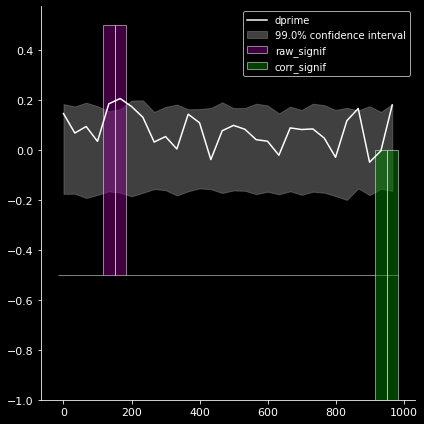

In [49]:
_  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, mean_type, context_pair=10, probe=4, grid=False)

AMT028b permutations SC consecutive_2 zeros


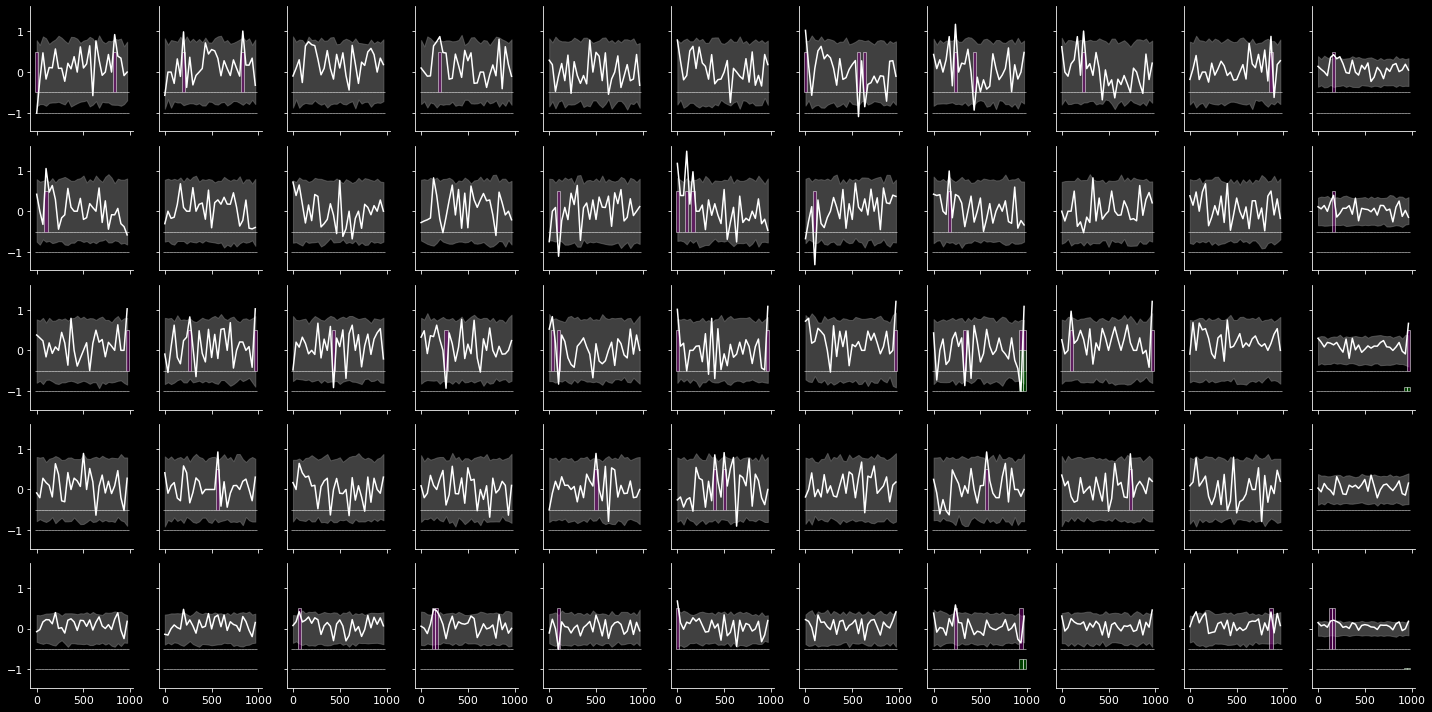

In [78]:
mean_type = 'zeros'
_  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, mean_type, context_pair=None, probe=None)

AMT028b permutations SC consecutive_2 zeros


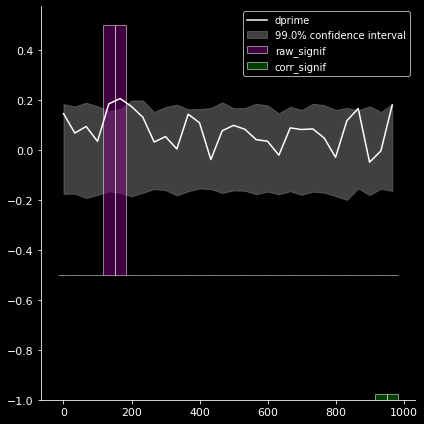

In [79]:
_  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, mean_type, context_pair=10, probe=4, grid=False)

CRD012b permutations SC consecutive_2 shuffles


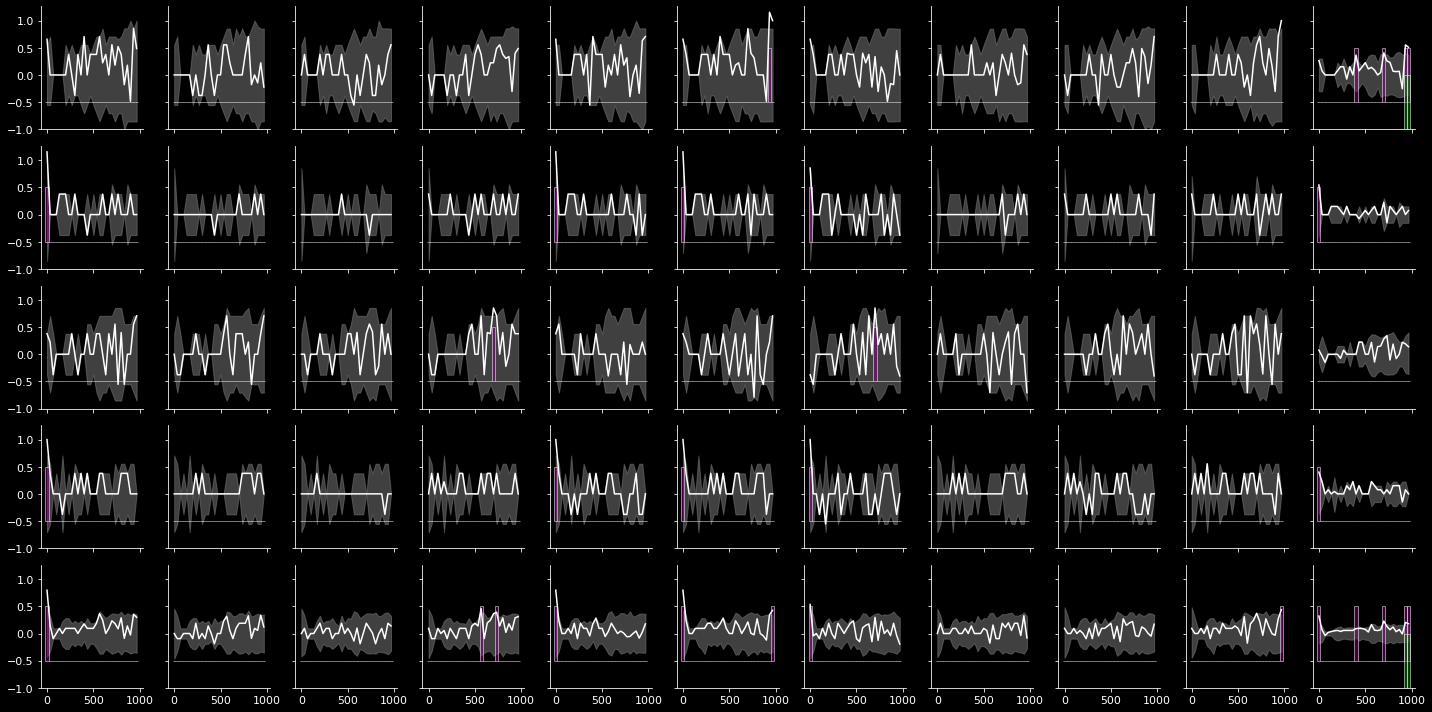

In [81]:
cellid = 'CRD012b-27-3'
site = 'CRD012b'
expt_name = 'permutations'
mult_corr = 'consecutive_2'
mean_type = 'shuffles'
_  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, mean_type, context_pair=None, probe=None)

CRD012b permutations SC consecutive_2 shuffles


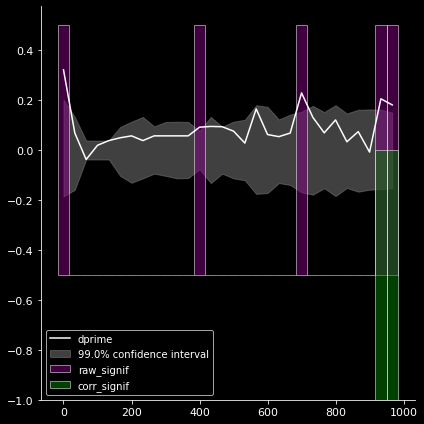

In [83]:
_  = plot_signif_summary(site, cellid, expt_name, fname, mult_corr, mean_type, context_pair=10, probe=4, grid=False)




here is a widget to plot anything.

In [104]:
sorted

metric                                                     significant_abs_mass_center  \
mult_comp_corr mean_signif_type stim_type    id                                          
consecutive_2  mean             permutations AMT028b-04-1                   966.040013   
               zeros            permutations AMT028b-04-1                   950.572803   
               shuffles         triplets     AMT026a-04-3                   949.933905   
                                permutations CRD012b-27-3                   948.940829   
               mean             permutations ley075b-12-1                   921.294807   
               zeros            permutations ley075b-12-1                   918.541963   
                                             AMT030a-17-1                   916.900357   
               mean             permutations AMT030a-17-1                   915.431557   
consecutive_4  shuffles         permutations CRD018d-39-3                   886.101367   
consecutive_2  shuffles         triplets     ley072b-18-1                   885.096899   
consecutive_3  shuffles         permutations CRD011c-30-3                   878.324643   
consecutive_4  shuffles         permutations CRD011c-30-3                   878.324643   
consecutive_2  zeros            permutations AMT030a-03-2                   871.242887   
consecutive_3  shuffles         triplets     AMT029a-06-1                   868.688001   
consecutive_2  mean             permutations CRD004a-46-4                   861.127704   
full           shuffles         triplets     AMT026a-04-3                   856.289872   
consecutive_3  shuffles         permutations ley072b-11-1                   853.634316   
consecutive_4  shuffles         permutations ley072b-11-1                   853.634316   
consecutive_2  shuffles         triplets     ley070a-18-2                   850.641206   
full           shuffles         triplets     ley070a-18-2                   850.641206   
consecutive_2  zeros            permutations CRD004a-46-4                   849.882623   
                                             AMT030a-09-4                   849.358023   
full           shuffles         permutations AMT032a-24-1                   847.396815   
                                triplets     ley070a-20-1                   845.459191   
consecutive_2  mean             permutations AMT030a-09-4                   842.617213   
consecutive_4  shuffles         permutations CRD003b-03-1                   830.819017   
consecutive_2  mean             permutations AMT030a-03-2                   830.772980   
full           shuffles         permutations AMT030a-28-2                   829.309971   
consecutive_2  shuffles         triplets     CRD003b-37-1                   812.540025   
full           shuffles         triplets     CRD003b-37-1                   812.540025   
...                                                                                ...   
consecutive_2  zeros            triplets     AMT028b-15-2                    11.355499   
               mean             permutations ley070a-18-2                    11.350420   
               shuffles         permutations ley070a-18-2                    11.350420   
                                triplets     CRD011c-20-1                    11.342816   
                                             CRD018d-45-2                    10.879798   
               mean             triplets     CRD018d-33-3                    10.734419   
               shuffles         triplets     CRD018d-33-3                    10.734419   
               zeros            triplets     CRD003b-41-1                    10.627089   
               mean             permutations CRD011c-40-4                    10.607900   
full           zeros            triplets     CRD019b-46-4                    10.481586   
                                permutations AMT028b-55-1                    10.373316   
consecutive_2  shuffles         triplets

In [105]:
_=interact_manual(plot_signif_summary,site='CRD012b', cellid='CRD012b-27-3',
                expt_name=['permutations', 'triplets'], fname=fixed('SC'),
                corr_name=['full', 'consecutive_2', 'consecutive_3', 'consecutive_4'],
                mean_type=['mean', 'zeros', 'shuffles'],
                context_pair=(0,10,1), probe=(0,4,1), grid=True)


interactive(children=(Text(value='CRD012b', description='site'), Text(value='CRD012b-27-3', description='celli…

In [106]:
#some good examples
good_eg = pivoted.sort_values(['significant_abs_sum','significant_abs_mass_center'], axis=0, ascending=[0,0])
good_eg


metric                                                     significant_abs_mass_center  \
mult_comp_corr mean_signif_type stim_type    id                                          
full           mean             permutations AMT029a-43-1                   385.555975   
               shuffles         permutations AMT029a-43-1                   376.660149   
consecutive_2  shuffles         permutations AMT029a-43-1                   363.817120   
consecutive_3  shuffles         permutations AMT029a-43-1                   363.817120   
consecutive_4  shuffles         permutations AMT029a-43-1                   363.817120   
consecutive_2  shuffles         permutations CRD012b-13-1                   496.102262   
consecutive_3  shuffles         permutations CRD012b-13-1                   496.102262   
consecutive_4  shuffles         permutations CRD012b-13-1                   496.102262   
full           shuffles         permutations CRD012b-13-1                   496.102262   
               mean             permutations CRD012b-13-1                   487.138692   
                                             CRD004a-64-1                   403.089589   
consecutive_2  mean             permutations CRD012b-13-1                   490.526405   
consecutive_3  mean             permutations CRD012b-13-1                   490.526405   
consecutive_2  mean             permutations AMT029a-43-1                   335.111768   
full           mean             permutations CRD004a-39-2                   134.356721   
               shuffles         permutations CRD004a-39-2                   136.546631   
                                             CRD004a-64-1                   405.796023   
consecutive_2  shuffles         permutations CRD004a-64-1                   398.637382   
consecutive_3  shuffles         permutations CRD004a-64-1                   398.637382   
consecutive_2  mean             permutations CRD004a-39-2                   112.266795   
full           mean             triplets     CRD011c-26-2                   500.226387   
               shuffles         triplets     CRD011c-26-2                   503.076144   
consecutive_2  shuffles         permutations CRD004a-39-2                   108.128891   
                                triplets     CRD011c-26-2                   517.108064   
consecutive_3  shuffles         triplets     CRD011c-26-2                   517.108064   
consecutive_4  shuffles         triplets     CRD011c-26-2                   517.108064   
consecutive_3  mean             permutations CRD004a-39-2                    94.872335   
consecutive_4  mean             permutations CRD004a-39-2                    94.872335   
                                             CRD012b-13-1                   449.231216   
               shuffles         permutations CRD004a-64-1                   389.245560   
...                                                                                ...   
consecutive_2  zeros            permutations AMT028b-04-1                   950.572803   
                                             CRD002a-12-1                    15.953134   
                                             ley075b-56-1                   149.632676   
                                             CRD012b-36-3                   683.426969   
                                             CRD004a-46-4                   849.882623   
                                             CRD002a-10-1                   250.000000   
                                             CRD018d-05-1                    16.666667   
                                             CRD003b-41-2                   551.150136   
                                             CRD012b-08-1                    85.755709   
                                             AMT026a-27-1                    14.966194   
                                             AMT030a-21-4                   549.036732   
                                        